In [134]:
import numpy as np
import matplotlib.pyplot as plt
from line_profiler import LineProfiler
import os

import gaez_data_loader
import simulation
import toolbox

# use importlib for now
import importlib
importlib.reload(simulation)
importlib.reload(toolbox)
importlib.reload(gaez_data_loader)

<module 'gaez_data_loader' from 'C:\\Users\\leoko\\PycharmProjects\\pythonProject\\gaez_data_loader.py'>

## Environments

Disjoint Environments

In Lattice.init_env_from_gaez(): Input environment contains water. Set to zero.


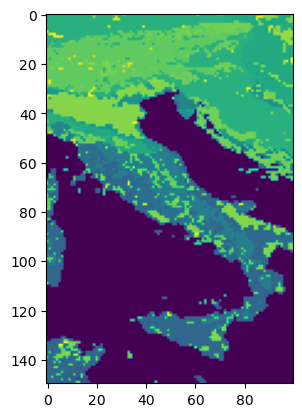

In [135]:
# get single GAEZ environment
base_dir = r"C:\Users\leoko\Documents\Vienna_CSH\gaez_v4_data"
fn = "aez_33_classes_low_res.tif"

gaez_data_single = gaez_data_loader.GlobalAezV4()
gaez_data_single.load(os.path.join(base_dir, fn), idx=0, verbose=False)
gaez_data_single.set_woi(r0=500, c0=2270, n_rows=150, n_cols=100) # crop europe  150 before
gaez_data_single.get_distance_matrix(verbose=False) # load distance matrix
env_gaez = gaez_data_single.get_env(water_var=0)

plt.imshow(gaez_data_single._array)

Non-disjoint environments

In Lattice.init_env_from_gaez(): Input environment contains water. Set to zero.
In Lattice.init_env_from_gaez(): Input environment contains water. Set to zero.
In Lattice.init_env_from_gaez(): Input environment contains water. Set to zero.


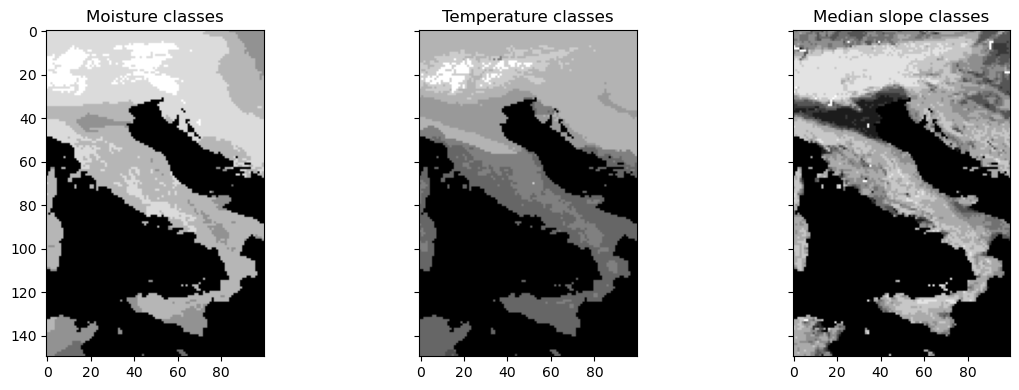

In [136]:
# load environments - here temperature, moisture, and median slope
env_list = []
base_dir = r"C:\Users\leoko\Documents\Vienna_CSH\gaez_v4_data"
fn_list = ["Gaez_Moisture_Regime_Class.tif", "Gaez_Thermal_Regime_Class.tif", "Gaez_Median_Slope_Class.tif"]

for fn in fn_list:
    gaez_data = gaez_data_loader.GlobalAezV4()
    gaez_data.load(os.path.join(base_dir, fn), idx=0, verbose=False)
    gaez_data.set_woi(r0=500, c0=2270, n_rows=150, n_cols=100) # crop europe  150 before
    gaez_data.get_distance_matrix(verbose=False) # load distance matrix
    env_gaez = gaez_data.get_env(water_var=0)
    env_list.append(env_gaez)
    env_list.append(gaez_data._array)  # for visualization

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 4), sharex=True, sharey=True)

ax1.imshow(env_list[1], cmap="gray")
ax1.set_title("Moisture classes")
ax2.imshow(env_list[3], cmap="gray")
ax2.set_title("Temperature classes")
ax3.imshow(env_list[5], cmap="gray")
ax3.set_title("Median slope classes")

fig.tight_layout()

save_path = r"C:\Users\leoko\Documents\Vienna_CSH\images_plot"
save_name = "moist_temp_slope.png"
fn = os.path.join(save_path, save_name)

# fig.savefig(fn, dpi=200)

In [137]:
# get multiple envs into one if desired
env_gaez_multiple = toolbox.get_envs_from_multiple_maps(env_list[1::2], water_var=0)

Artificial environments

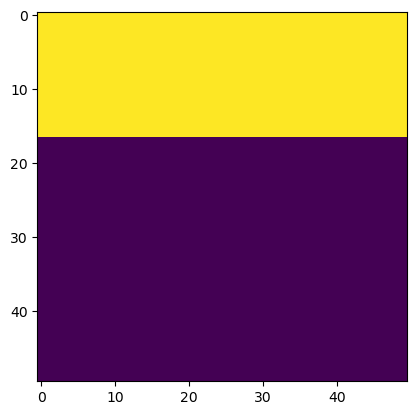

In [138]:
# engineer artificial environment
env_artificial = np.zeros([50, 50, 4])

env_artificial[:17, :, 0] = 1
env_artificial[10:25, :, 3] = 1

env_artificial[17:34, :, 1] = 1
env_artificial[34:, :, 2] = 1

plt.imshow(env_artificial[..., 0])

## Geography modulation

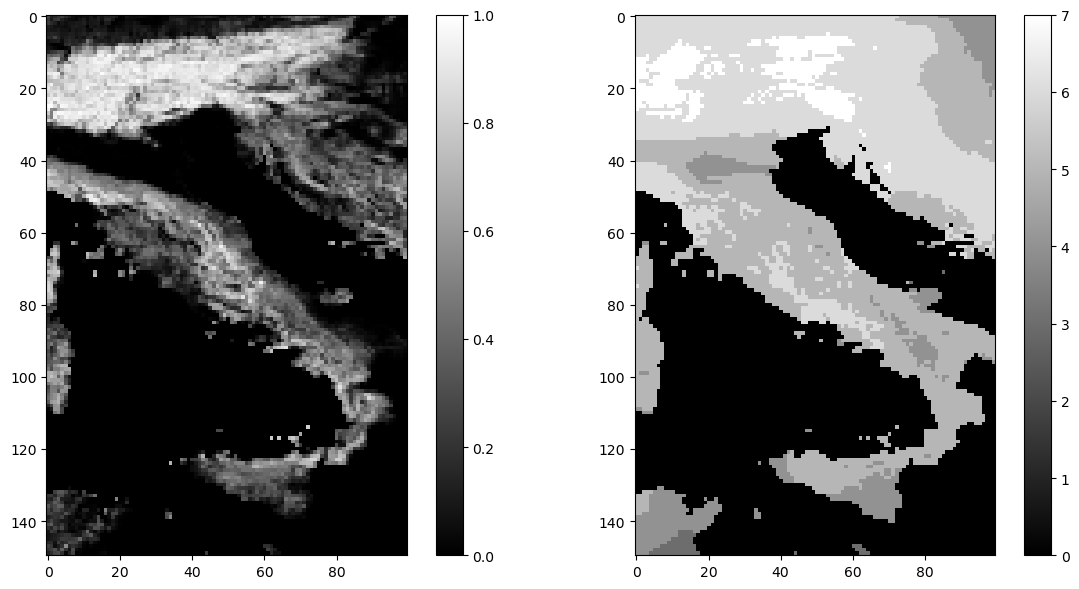

In [139]:
# Get weighted elevation average
names = ["Gaez_ShareOfClass_58_Range.tif", "Gaez_ShareOfClass_816_Range.tif", "Gaez_ShareOfClass_1630_Range.tif",
         "Gaez_ShareOfClass_3045_Range.tif", "Gaez_ShareOfClass_45More_Range.tif"]

elevations_median = [(8 + 5) / 2, (8 + 16) / 2, (16 + 30) / 2, (30 + 45) / 2, 50]  # order must match names
data_sets = []

for fn in names:
    gaez_data = gaez_data_loader.GlobalAezV4()
    gaez_data.load(os.path.join(base_dir, fn), idx=0, verbose=False)
    gaez_data.set_woi(r0=500, c0=2270, n_rows=150, n_cols=100)

    share_class_data = np.copy(gaez_data._array)

    test_mask = share_class_data < 0  # water areas
    share_class_data[test_mask] = 0

    data_sets.append(share_class_data)

weighted_elevation = np.zeros_like(data_sets[0])

for median_slope, data in zip(elevations_median, data_sets):  # weighted sum
    weighted_elevation += median_slope * data

# normalize
elevation_penalties = weighted_elevation / np.amax(weighted_elevation)

# add geographical penalty
# lattice.load_geo_constraints(elevation_penalties)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
pl1 = ax1.imshow(elevation_penalties, cmap="gray")
fig.colorbar(pl1, ax=ax1)
pl2 = ax2.imshow(env_list[1], cmap="gray")
fig.colorbar(pl2, ax=ax2)

fig.tight_layout()

# fig.savefig(os.path.join(save_dir, "penalites_and_map.png"), dpi=200)

## Create Instance

In [140]:
# load instance
params_instance = {"num_iter": 5_000, "seed": 51, "idx_start": (0, 0), "population_growth_rate": 1 / 30,
                   "max_productivity": 800, "n_rows": 150, "n_cols": 100, "starting_pop": 10}

base_abm = simulation.Lattice(**params_instance)

In meth: lattice.load_env: The environment has 10 mutually exclusive types.


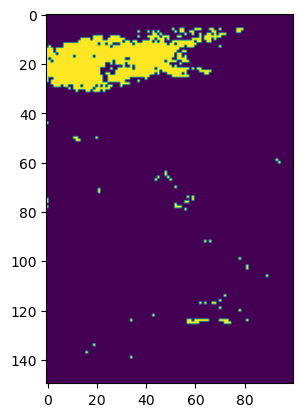

In [141]:
# load environment - here random
base_abm.load_env(env=env_gaez, kind="custom", num_env_vars=None, correlation_length=0.05, verbose=True)

# visualize
plt.imshow(base_abm.env[:, :, 8])

## Fission Rules

In [142]:
# add max distance if desired
max_distance = 20  # kilometres

# load gaez data instance to class - this should be reworked as a subclass
base_abm.load_gaez_instance(gaez_data_single)

In [143]:
# set fission rules
fission_bounds = (params_instance["starting_pop"], 1 * np.floor(base_abm.productivity_step_size))

migration_threshold = 1 * np.floor(base_abm.productivity_step_size)  # requires at least one matching skill

params_fission = {"migration_threshold": migration_threshold, "include_diagonals": False, "search_distance_pixels": 2,
                  "search_intelligently": True, "max_distance_km": max_distance, "dist_type": "linear",
                  "params_are_relative": False}

base_abm.set_fission_rules(fission_bounds, **params_fission)

# Check set rates in absolute numbers to validate if there are no errors
print("Maximum carrying capacity is", base_abm.max_productivity)
print("Bounds for fission probabilities (min, max) are", base_abm.pop_min, base_abm.pop_max)
print("Number of uninhabitable cells is", np.sum(base_abm.is_uninhabitable))
print("Migration threshold is", base_abm.migration_thresh)

Villagers have maximum search radius of 20 kilometres.
Maximum carrying capacity is 800
Bounds for fission probabilities (min, max) are 10 80.0
Number of uninhabitable cells is 6752
Migration threshold is 80.0


## Skill mutation rules

In [144]:
# set mutation rules
n_min, n_max = params_instance["starting_pop"], 1 * np.floor(base_abm.productivity_step_size)

params_adaptive = {"p_gain_useful": 1., "p_gain_useless": 0.01, "p_lose_useful": 0, "p_lose_useless": 1.,
                   "dist_type": "linear", "n_min": n_min, "n_max": n_max, "bounds_are_relative": False}

params_mutation = {"env_mutation_rate": None, "skill_mutation_rate": 0.01, "skill_mutation_method": "adaptive",
                   "params_adaptive": params_adaptive}

base_abm.set_mutation_rules(**params_mutation)

print("Base skill mutation rate is", base_abm.skill_mutation_rate)
print("Bounds for skill mutation are (min, max):", base_abm.min_pop_mutation, base_abm.max_pop_mutation)

Base skill mutation rate is 0.01
Bounds for skill mutation are (min, max): 10 80.0


## Other parameters

In [145]:
# decide if speed-up is possible
base_abm.set_speed_params()
print("Use valid neighbor flag:", base_abm.use_valid_neighs_flag)

Use valid neighbor flag: True


In [146]:
# Set geographical penalties
base_abm.load_geo_constraints(elevation_penalties, geo_constraints_scale=0)  # 0 is no constraints

In [147]:
# add line profiler if desired
profiler_line = LineProfiler()
profiler_line.enable_by_count()
profiler_line.add_function(base_abm.migrate_to)

In [148]:
# customize initial skill vector - usually set identical to environment
print(base_abm.env[base_abm.r0, base_abm.c0])

base_abm.skills[base_abm.r0, base_abm.c0] = base_abm.env[base_abm.r0, base_abm.c0]

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## Run

In [149]:
# run
base_abm.run()

100%|██████████| 4999/4999 [15:12<00:00,  5.48it/s]


In [150]:
# line profiler output
profiler_line.print_stats()

Timer unit: 1e-07 s

Total time: 822.761 s
File: C:\Users\leoko\PycharmProjects\pythonProject\simulation.py
Function: migrate_to at line 426

Line #      Hits         Time  Per Hit   % Time  Line Contents
   426                                               def migrate_to(self, idx_r, idx_c, search_empty_cells=True):
   427                                                   """ This is the core loop that is intended for NUMBA to vastly speed up the FOR loop.
   428                                                   Loops through occupied cells, selects a migration location for each cell based on a prob. distribution.
   429                                                   Reverse search works as follows:
   430                                                   1 - get populations from all sites a distance d away from the empty site
   431                                                   2 - calculate carrying capacity (productivity) using env from empty site and skills at occupied site

## Get statistics

In [151]:
save_dir = r"C:\Users\leoko\Documents\Vienna_CSH\images_plot"

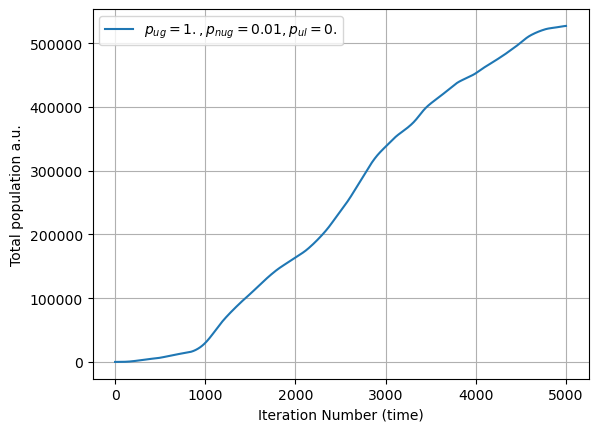

In [154]:
# get population
population = base_abm.population
# population /= base_abm.productivity_step_size

population[np.isnan(population)] = 0 # to clean for NaN values
pop_total = np.sum(population, axis=(1, 2))

fig = plt.figure()
plt.plot(pop_total, label=r"$p_{ug}=1., p_{nug}=0.01, p_{ul}=0$.")
plt.ylabel("Total population a.u.")
plt.xlabel("Iteration Number (time)")
plt.grid()
plt.legend()

# fig.savefig(os.path.join(save_dir, "Italy_only.png"))

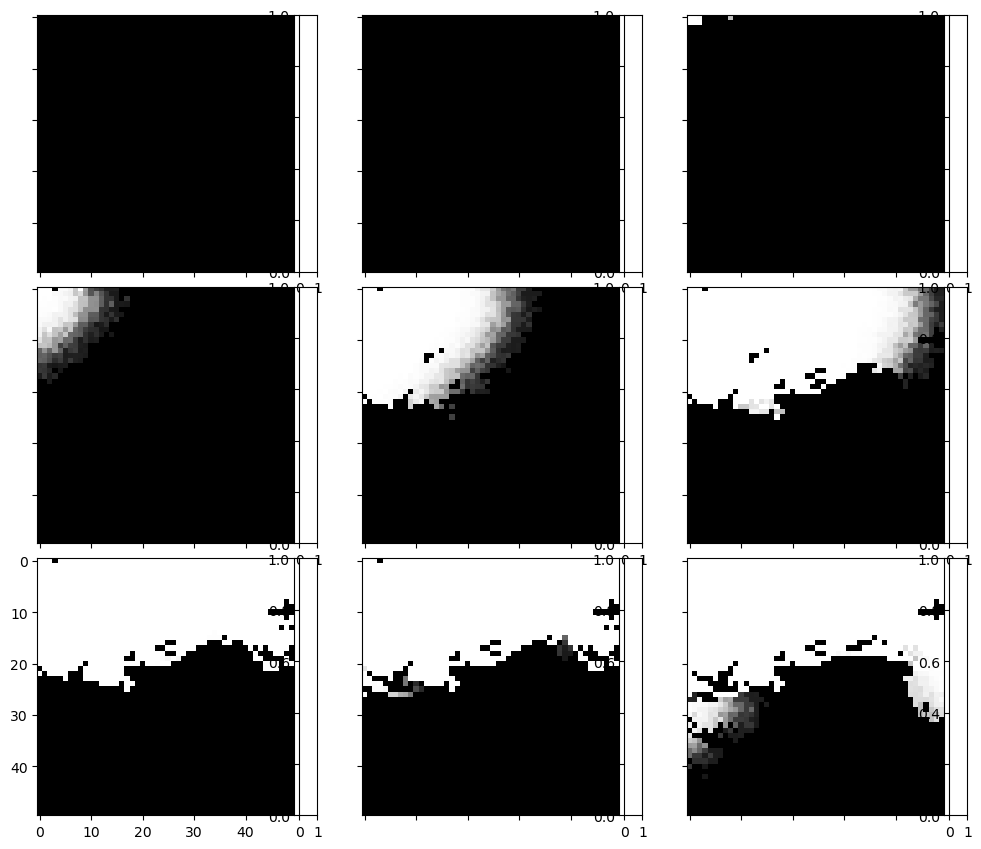

In [158]:
# Plot population at different instances of time
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(12, 12))

# A grid of 2x2 images. Each image has its own colorbar.
grid = ImageGrid(
    fig, 111,  # similar to fig.add_subplot(144).
    nrows_ncols=(3, 3), axes_pad=(0.45, 0.15), label_mode="1", share_all=True,
    cbar_location="right", cbar_mode="each", cbar_size="7%", cbar_pad="2%")

idx = 100
for ax, cax in zip(grid, grid.cbar_axes):
    im = ax.imshow(base_abm.population[idx][10:60, 10:60] / base_abm.productivity_step_size, cmap="gray")
    idx += 300

# fig.savefig(os.path.join(save_dir, "Italy_only_pop_instances.png"), dpi=200)